# Prior Monte Carlo

Prior-based (or "unconstrained") Monte Carlo is a usefull, but quite often underused, analysis. It is conceptually simple, does not require much in terms of algorithmic controls and forces the modeller to think about the prior parameter probability distribution - both the mean vector (i.e. the initial parameter values) and the prior parameter covariance matrix. 

The idea is simple: sample many sets of parameters (i.e. an ensemble) from a prior probability distribution and simulate the model with this parameter ensemble. Do not try and fit historical data (yet!). Do not throw any of the simulations out because they "do not represent historical data well". This allows us to explore the entire range of model outcomes across the (prior) range of parameter vaues. It let's us investigate model stability (e.g. can the model setup handle the parameters we are throwing at it?). It also let's us start to think critically about what observations the model will be able to match.

Sometimes, it shows us that history matching is not required - saving us a whole lot of time and effort!

In this notebook we will demonstrate:
 - how to generate a parameter ensemble, making use of a (previously prepared) parameter covariance matrix.
 - how to use `pyemu` to run `pestpp` in parallel
 - using `pestpp-swp` to batch process a series of modeller-prepared model runs
 - using `pestpp-ies` to accomplish the same thing
 - post-processing stochastic model outputs

### 1. The modified Freyberg PEST dataset

The modified Freyberg model is introduced in another tutorial notebook (see "freyberg intro to model"). The current notebook picks up following the "freyberg psfrom pest setup" notebook, in which a high-dimensional PEST dataset was constructed using `pyemu.PstFrom`. You may also wish to go through the "intro to pyemu" notebook beforehand.

The next couple of cells load necessary dependencies and call a convenience function to prepare the PEST dataset folder for you. This is the same dataset that was constructed during the "freyberg pstfrom pest setup" tutorial. Simply press `shift+enter` to run the cells.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyemu
import pandas as pd
import matplotlib.pyplot as plt;

import sys
sys.path.append("..")
# import pre-prepared convenience functions
import herebedragons as hbd

In [2]:
# specify the temporary working folder
t_d = os.path.join('freyberg6_template')

In [3]:
# use the convenience function to get the pre-preprepared PEST dataset;
# this is the same dataset consutructed in the "obs and weights" tutorial
hbd.dir_cleancopy(org_d=os.path.join('..','..', 'models','freyberg_obs_and_weights'), 
                new_d=t_d)
# get and unzip the prior covariance JCB file
hbd.unzip(os.path.join('..','..','models','prior_cov.zip'), os.path.join(t_d))

Files copied from:..\..\models\freyberg_obs_and_weights
Files copied to:freyberg6_template


Load the PEST control file as a `Pst` object.

In [4]:
pst = pyemu.Pst(os.path.join(t_d, 'freyberg_mf6.pst'))

### 2. Generating the Prior Parameter Ensemble

We can use one of the `pyemu.ParameterEnsemble` class `draw` methods to generate stochastic values from (multivariate) (log) gaussian, uniform and triangular distributions.  Much of what we do is predicated on the gaussian distribution, so let's use that here.

These `draw` methods use initial parameter values in the control file (the `Pst.parameter_data.parval1` attribute) as the $\boldsymbol{\mu}$  (mean) prior parameter vector.  

The gaussian draw accepts a `cov` arg which can be a `pyemu.Cov` instance.  If this isn't passed, then the draw method constructs a diagonal covariance matrix from the parameter bounds (assuming a certain number of standard deviations represented by the distance between the bounds - the `sigma_range` argument). 

Recall from the "freyberg pstfrom pest setup" tutorial, that we generated a parameter covariance matrix and stored this as an external file named `prior_cov.jcb`. This covariance matrix describes our prior parameter uncertainties and how these are correlated to each other. Let's start by reading this file as a `pyemu.Cov` object.

In [5]:
cov = pyemu.Cov.from_binary(os.path.join(t_d, 'prior_cov.jcb'))

# take a peek at the matrix if you like
#cov.to_dataframe().head()

In [6]:
pe = pyemu.ParameterEnsemble.from_gaussian_draw(pst=pst, # the pest control file from which parameter means and bounds are obtained
                                                cov=cov, # the parameter prior covariance matrix
                                                num_reals=200) # the number of realisations in the ensemble
# enforce parameter bounds
pe.enforce()

drawing from group ghbcond_cn
drawing from group ghbcond_gr
drawing from group ghbhead_cn
drawing from group ghbhead_gr
drawing from group npf_k33_layer1_cn
drawing from group npf_k33_layer1_gr
drawing from group npf_k33_layer1_pp
drawing from group npf_k33_layer2_cn
drawing from group npf_k33_layer2_gr
drawing from group npf_k33_layer2_pp
drawing from group npf_k33_layer3_cn
drawing from group npf_k33_layer3_gr
drawing from group npf_k33_layer3_pp
drawing from group npf_k_layer1_cn
drawing from group npf_k_layer1_gr
drawing from group npf_k_layer1_pp
drawing from group npf_k_layer2_cn
drawing from group npf_k_layer2_gr
drawing from group npf_k_layer2_pp
drawing from group npf_k_layer3_cn
drawing from group npf_k_layer3_gr
drawing from group npf_k_layer3_pp
drawing from group rch_recharge_10_gr
drawing from group rch_recharge_10_pp
drawing from group rch_recharge_10_tcn
drawing from group rch_recharge_11_gr
drawing from group rch_recharge_11_pp
drawing from group rch_recharge_11_tcn
dr

In [7]:
pe.loc[:,pst.par_names[0]]

0      1.499719
1      1.598004
2      0.710687
3      1.759879
4      0.527595
         ...   
195    0.795865
196    0.961521
197    0.530256
198    2.407379
199    1.155516
Name: pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1, Length: 200, dtype: float64

<AxesSubplot:>

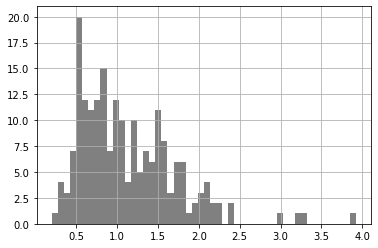

In [8]:
pe.loc[:,pst.par_names[0]].hist(bins=50,facecolor="0.5")

Now that we have generated the prior ensebmle, we can record it as an external file for future use. This can be a CSV or binary (JCB or JCO) file.

Let's record it as a JCB (the file will be a bit smaller).

In [9]:
pe.to_binary(os.path.join(t_d, 'prior_pe.jcb')) 

### 3. Run the Ensemble in Parallel

Here we are going to make use of the `pestpp-swp`. Alternatively, we could use `pestpp-ies` instead.

`pestpp-swp` runs a a a model using a suite of parameter fields which must be supplied in a CSV or binary file. Model outputs calculated with these parameter fields are recorded in another CSV file. By default, `pestpp-swp` assumes that the parameter fields are in the file `sweep_in.csv`. If they are not (as is our case) the user must provide the respective file name. 

So let's start by specifying the parameter input file fro `pestpp-swp`:

In [10]:
pst.pestpp_options['sweep_parameter_csv_file'] = 'prior_pe.jcb'

Then, re-write the PEST control file. If you open `priormc.pst` in a text editor, you'll see a new PEST++ control variable has been added.

In [11]:
pst.write(os.path.join(t_d, 'priormc.pst'))

noptmax:0, npar_adj:25429, nnz_obs:144


Now, we are going to run `pestpp-swp` in parallel. 

To speed up the process, you will want to distribute the workload across as many parallel agents as possible. Normally, you will want to use the same number of agents (or less) as you have available CPU cores. Most personal computers (i.e. desktops or laptops) these days have between 4 and 10 cores. Servers or HPCs may have many more cores than this. Another limitation to keep in mind is the read/write speed of your machines disk (e.g. your hard drive). PEST and the model software are going to be reading and writting lots of files. This often slows things down if agents are competing for the same resources to read/write to disk.

The first thing we will do is specify the number of agents we are going to use.

# Attention!

You must specify the number which is adequate for ***your*** machine! Make sure to assign an appropriate value for the following `num_workers` variable:

In [12]:
num_workers = 4

Next, we shall specify the PEST run-manager/master directory folder as `m_d`. This is where outcomes of the PEST run will be recorded. It should be different from the `t_d` folder, which contains the "template" of the PEST dataset. This keeps everything separate and avoids silly mistakes.

In [13]:
m_d = os.path.join('master_priormc')

The following cell deploys the PEST agents and manager and then starts the run using `pestpp-swp`. Run it by pressing `shift+enter`.

If you wish to see the outputs in real-time, switch over to the terminal window (the one which you used to launch the `jupyter notebook`). There you should see `pestpp-swp`'s progress. 

If you open the tutorial folder, you should also see a bunch of new folders there named `worker_0`, `worker_1`, etc. These are the agent folders. The `master_priormc` folder is where the manager is running. 

This run should take several minutes to complete (depending on the number of workers and the speed of your machine). If you get an error, make sure that your firewall or antivirus software is not blocking `pestpp-swp` from communicating with the agents (this is a common problem!).

> **Pro Tip**: Running PEST from within a `jupyter notebook` has a tendency to slow things down and hog alot of RAM (at least if you are using Visual Studio Code, as I am). When modelling in the "real world" it is more efficient to implement workflows in scripts which you can call from the command line. For example, for this case it took me 20min when running `pestpp-swp` from the `jupyter notebook`, but only 5min when running form the comand line. If you inspect the tutorial folder, you will find a file named `run_swp.py` that accomplishes this. 

In [14]:
pyemu.os_utils.start_workers(t_d, # the folder which contains the "template" PEST dataset
                            'pestpp-swp', #the PEST software version we want to run
                            'priormc.pst', # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            )

### 4. Explore the Outcomes

By default, `pestpp-swp` writes the results of the parametric sweep to a csv file called `sweep_out.csv`.  This file has columns for each observation listed in the control file, plus columns for total phi and phi for each observation group (calculated using the weights in the control file).  It also has columns for the `input_run_id` and `failed_flag` to help you align these outputs with the inputs and also track any failed runs.



Let's check if any runs failed:

In [14]:
obs_df = pd.read_csv(os.path.join(m_d,"sweep_out.csv"),index_col=0)
print('number of realization in the ensemble before dropping: ' + str(obs_df.shape[0]))

number of realization in the ensemble before dropping: 200


In [15]:
obs_df = obs_df.loc[obs_df.failed_flag==0,:]
print('number of realization in the ensemble **after** dropping: ' + str(obs_df.shape[0]))

number of realization in the ensemble **after** dropping: 200


Are they the same? Good, that means none failed. If any had failed, this would be an opportunity to go and figure out why, by identifying the parameter realisations that failed and figuring out why they may have had trouble converging. This might lead to discovering inadequacies in the model configuration and/or parameterisation.  Better to catch them now, before spending alot of effort history matching the model... 

We can take a look at the distribution of Phi obtained for the ensemble. Some pretty high values there. But that's fine. We are not concerned with getting a "good fit" in prior MC.

<AxesSubplot:>

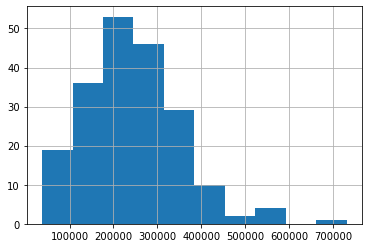

In [16]:
obs_df.phi.hist()

More important is to inspect whether the ***distribution*** of simulated observations encompass measured values.Our first conerns is to ensure that the model is ***able*** to captured observed behaviour. If measured values do not fall within the range of simualted values, this is a sign that something ain't right and we should revisit our model or prior parameter distributions.


A quick check is to plot stochastic (ensemble-based) 1-to-1 plots. We can plot 1to1 plots for obsvervation groups using the `pyemu.plot_utils.ensemble_res_1to1()` method. However, in our case that will result in lots of plots (we have many obs groups!). 

In [17]:
#pyemu.plot_utils.ensemble_res_1to1(obs_df, pst);

Feel free to uncomment the previous cell and see what happens. This can be usefull for a quick review, but for the purposes of this tutorial, let's just look at four observation groups (recall, each group is made up of a time series of observations from a single location).

Now, this plot does not look particularily pretty...but we aren't here for pretty, we are here for results! What are we concerned with? Whether the range of ensemble simulated outcomes form the prior covers the measured values. Recall that plots on the left are 1to1 plots and on the right the residuals ar edisplayed.  In both cases, a grey line represents the range of simulated values for a given observation

In plots on the right, each grey line should interesect the 1-to-1 line. In the plots on the right, each grey line should intersect the "zero-residual" line. 

<Figure size 576x756 with 0 Axes>

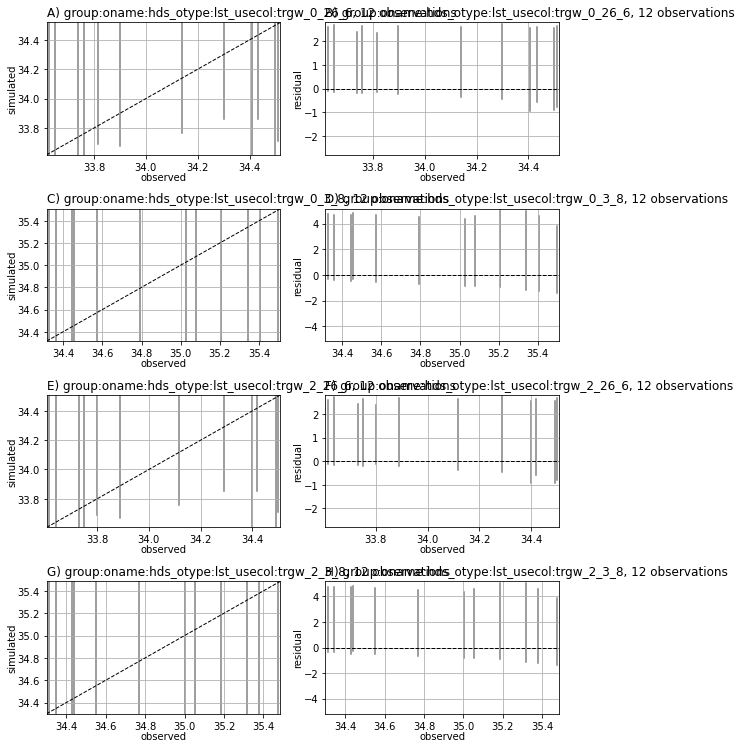

In [18]:
pyemu.plot_utils.ensemble_res_1to1(obs_df, pst, skip_groups=pst.nnz_obs_groups[4:]); 

As we can see above, the prior covers the "measured" values (which is good).

But hold on a second! What about measurement noise? If we are saying that it is *possible* that our measurements are wrong by a certain amount, shouldn't we make sure our model can represent conditions in which they are? Yes, of course!

No worries, `pyemu` has you covered. Let's quickly cook up an ensemble of observations with noise. (Recall we recorded a covariance matrix of observation oise dugin the "freyberg pstfrom pest setup" notebook; this has also been discussed int he "observation and weights" notebook.)

In [19]:
obs_cov = pyemu.Cov.from_binary(os.path.join(t_d, 'obs_cov.jcb'))
obs_plus_noise = pyemu.ObservationEnsemble.from_gaussian_draw(pst=pst, cov=obs_cov);

drawing from group oname:hds_otype:lst_usecol:trgw_0_26_6
drawing from group oname:hds_otype:lst_usecol:trgw_0_3_8
drawing from group oname:hds_otype:lst_usecol:trgw_2_26_6
drawing from group oname:hds_otype:lst_usecol:trgw_2_3_8
drawing from group oname:hdstd_otype:lst_usecol:trgw_0_26_6
drawing from group oname:hdstd_otype:lst_usecol:trgw_0_3_8
drawing from group oname:hdstd_otype:lst_usecol:trgw_2_26_6
drawing from group oname:hdstd_otype:lst_usecol:trgw_2_3_8
drawing from group oname:hdsvd_otype:lst_usecol:trgw_0_26_6
drawing from group oname:hdsvd_otype:lst_usecol:trgw_0_3_8
drawing from group oname:sfr_otype:lst_usecol:gage_1
drawing from group oname:sfrtd_otype:lst_usecol:gage_1


OK, now let's plot that again but with observation noise. 

Aha! Good, not only do our ensemble of model outcomes cover the measured values, but they also entirely cover the range of measured values with noise (red shaded area in the plot below). 

<Figure size 576x756 with 0 Axes>

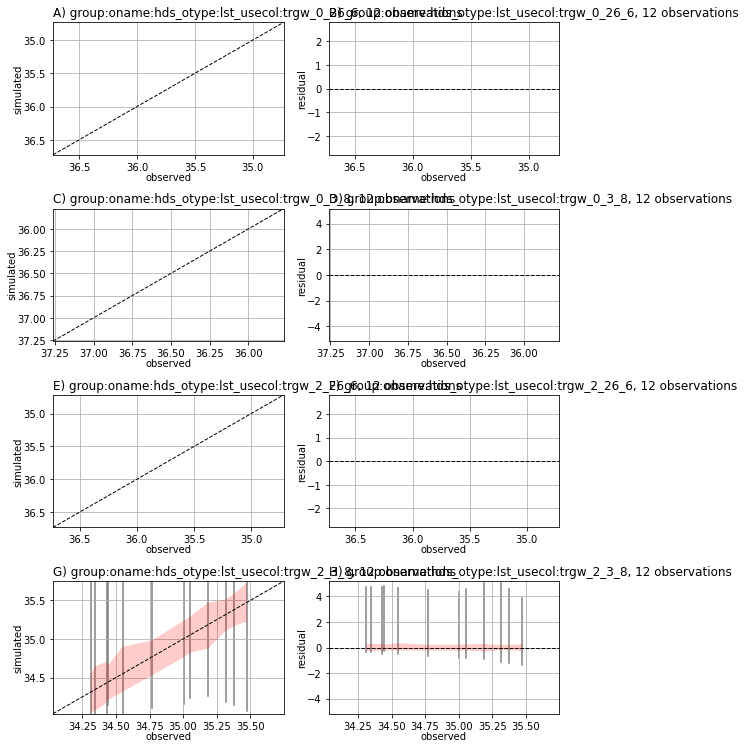

In [20]:
pyemu.plot_utils.ensemble_res_1to1(obs_df, pst, skip_groups=pst.nnz_obs_groups[4:], base_ensemble=obs_plus_noise); 

Another, perhaps coarser, method to quickly explore outcomes is to look at histograms of observations. 

The following figure groups obsevrations according to type (just to lump them together and make a smaller plot) and then plots histograms of observation values. Grey shaded columns represent simulated values from the prior. Red shaded columns represent the ensemble of measured values + noise. The grey columns should ideally be spread wider than the red columns.

<Figure size 576x756 with 0 Axes>

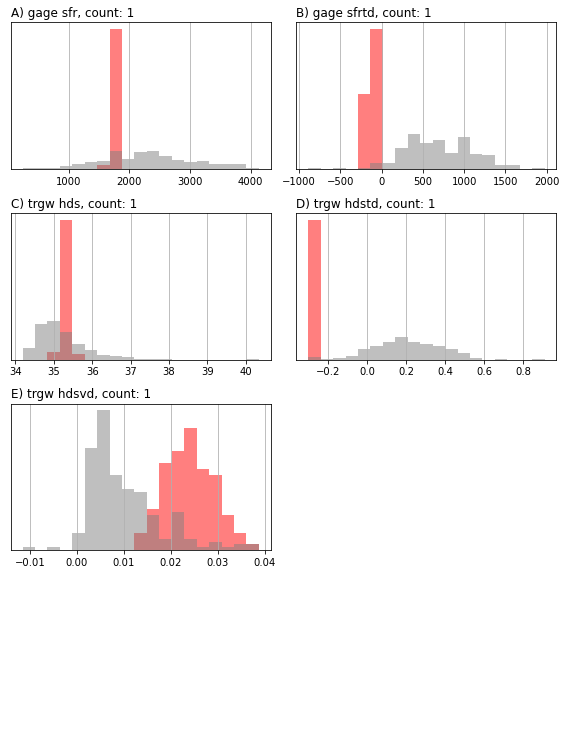

In [21]:
plot_cols = pst.observation_data.loc[pst.nnz_obs_names].apply(lambda x: x.usecol + " "+x.oname,axis=1).to_dict()
plot_cols = {v: [k] for k, v in plot_cols.items()}
pyemu.plot_utils.ensemble_helper({"r":obs_plus_noise,"0.5":obs_df}, 
                                  plot_cols=plot_cols,bins=20,sync_bins=True,
                                  )
plt.show();

### 5. Forecasts

As usual, we bring this story back to the forecasts - after all they are why we are modelling.

In [22]:
pst.forecast_names

['oname:sfr_otype:lst_usecol:tailwater_time:367.0',
 'oname:sfr_otype:lst_usecol:headwater_time:640.0',
 'oname:hds_otype:lst_usecol:trgw_0_9_1_time:640.0']

The following cell will plot the distribution of each forecast obtained by running the prior parameter ensemble. Because we are using a synthetic model, we also have the privilege of being able to plot the "truth" (in the real world we dont know the truth of course). 

Many modelling analyses could stop here. If outcomes from a prior MC analysis show that the simulated distribution of forecasts *does not* cause some "bad-thing" to happen within an "acceptable" confidence, then you are done. No need to go and do expensive and time-consuming history-matching! 

On the other hand, if the uncertainty (e.g. variance) is unacceptably wide, then it *may* be justifiable to try to reduce forecast unertainty through history matching. But only if you have forecast-sensitive observation data, and if the model is amenable to assimilating these data! How do I know that you ask? Worry not, we will get to this in subsequent tutorials.


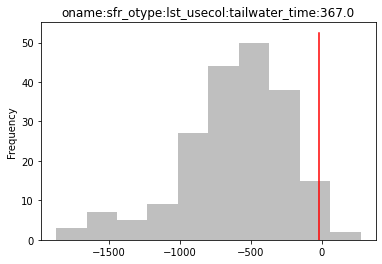

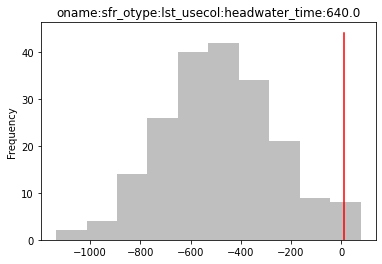

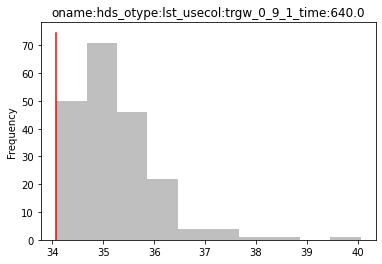

In [28]:
for forecast in pst.forecast_names:
    plt.figure()
    ax = obs_df.loc[:,forecast].plot(kind="hist",color="0.5",alpha=0.5)
    ax.set_title(forecast)
    fval = pst.observation_data.loc[forecast,"obsval"]
    ax.plot([fval,fval],ax.get_ylim(),"r-")

### Prior MC without Covariance

The workflow above demonstrated how to use `pestpp-swp` to undertake a "sweep" of model runs. Here, we undertook prior Monte Carlo by running models with an ensemble of parameter sets sampled from the prior parameter probability distribution. 

The same can be accomplished with `pestpp-ies` by assigning the `NOPTMAX` control variable to -1 and either providing `pestpp-ies` with a predefined parameter ensebmle (the same as we did for `pestpp-swp`) or by providing the parameter covariance matrix and allowing `pestpp-ies` to sample from the prior itself.

The next few cells do something slightly different. Here we will use `pestpp-ies` to undertake prior MC, but assuming to correlation between parameters. Here, prior parameter uncertainty is diagonal and determined solely based on the parameter bounds in the PEST control file. 

First set some `pest++` options and re-write the control file.

In [29]:
pst.pestpp_options['ies_num_reals'] = 200
pst.control_data.noptmax = -1
pst.write(os.path.join(t_d,"freyberg_diagprior.pst"))

noptmax:-1, npar_adj:25429, nnz_obs:144


Run `pstpp-ies`. This should take about the same amount of time as `pestpp-swp` did.

In [30]:
m_d = "master_diagonal_prior_monte_carlo" 
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg_diagprior.pst",num_workers=num_workers,
                             master_dir=m_d)

Now read in the results. Let's just look at the forecasts. (Feel free to repeat the plots we did above if you wish to compare them.)

So, what do you think? Did ignoring parameter covariance make our forecasts more or less robust? It seems like our prior is failing to capture some of the "true" values now. This highlights the role of connectivity and "hydraulic structures" in some groundwater predictions and the importance of having a well constructed prior. 

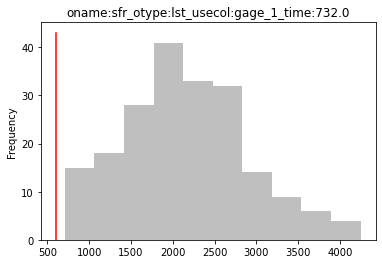

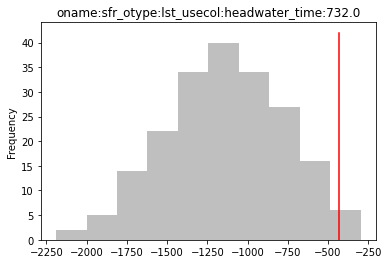

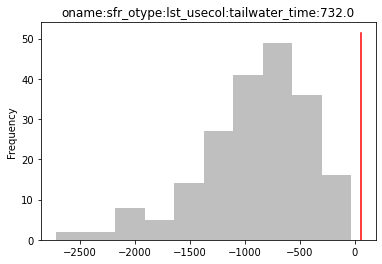

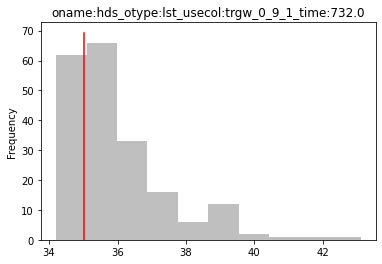

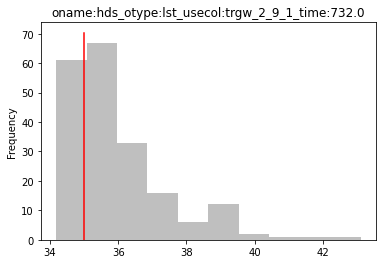

In [ ]:
obs_df = pd.read_csv(os.path.join(m_d,"freyberg_diagprior.0.obs.csv"),index_col=0)

for forecast in pst.forecast_names:
    plt.figure()
    # plot histogram of forecast values recorded in the simulated prior observation csv
    ax = obs_df.loc[:,forecast].plot(kind="hist",color="0.5",alpha=0.5)
    ax.set_title(forecast)
    # plot the forecast value in the "observation data"; this value happens to be the "truth"
    fval = pst.observation_data.loc[forecast,"obsval"]
    ax.plot([fval,fval],ax.get_ylim(),"r-")